In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torchvision.models as models
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from PIL import ImageFile
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
train_data_dir = '/content/drive/My Drive/Colab Notebooks/covid_detection/dataset/train6'
valid_data_dir = '/content/drive/My Drive/Colab Notebooks/covid_detection/dataset/validation6'
test_data_dir = '/content/drive/My Drive/Colab Notebooks/covid_detection/dataset/test6'

In [ ]:
# num_class = 2
# image_dim = 224
batch_size = 8

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

train_data_transform = transforms.Compose([transforms.Resize(244),
                                           transforms.CenterCrop(224),
                                           transforms.RandomRotation(10),                                          
                                           transforms.RandomHorizontalFlip(),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean=0.485,
                                                                std=0.229)])

valid_data_transform = transforms.Compose([transforms.Resize(244),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean= 0.485 ,std= 0.229)])

test_data_transform = transforms.Compose([transforms.Resize(224),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean= 0.485,
                                                                std= 0.229)])

train_data = datasets.ImageFolder(train_data_dir, transform=train_data_transform)
valid_data = datasets.ImageFolder(valid_data_dir, transform=valid_data_transform)
test_data = datasets.ImageFolder(test_data_dir, transform=test_data_transform)
train_data_load = DataLoader(train_data, batch_size = batch_size, shuffle = True)
valid_data_load = DataLoader(valid_data, batch_size = batch_size, shuffle = True)
test_data_load = DataLoader(test_data,batch_size=batch_size, shuffle = True)

In [ ]:
use_cuda = torch.cuda.is_available()

In [ ]:
len(valid_data_load)

25

In [ ]:
loaders_transfer = {'train': train_data_load, 'valid': valid_data_load, 'test': test_data_load}

In [ ]:
model_transfer = models.resnet101(pretrained=True)
model_transfer.out = nn.Linear(2048, 2)

if use_cuda:
    model_transfer = model_transfer.cuda() 

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

In [ ]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.parameters(), lr=0.001)

In [ ]:
tl,vl,ta=[],[],[]
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        train_loss = 0.0
        valid_loss = 0.0
        
        correct=0
        total=0

        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            out = model(data)
            
            loss = criterion(out, target)
            
            loss.backward()
            optimizer.step()
            train_loss += ((1/(batch_idx + 1)) * (loss.data - train_loss))
            
            _, predicted = out.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            out = model(data)
            
            loss = criterion(out, target)
            valid_loss += ((1/(batch_idx + 1)) * (loss.data - valid_loss))
            
        ta.append(100. * correct/total) 
            
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.5f} \tValidation Loss: {:.5f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        tl.append(train_loss)
        vl.append(valid_loss)
        
        #save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Valid loss decrease to  ({:.5f} -> {:.5f}). Saving model ...'.format(valid_loss_min,valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
   
    # return trained model
    return model

In [ ]:
n_epochs = 45
model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

Epoch: 1 	Training Loss: 1.18256 	Validation Loss: 2.12226
Valid loss decrease to  (inf -> 2.12226). Saving model ...
Epoch: 2 	Training Loss: 0.42085 	Validation Loss: 0.52112
Valid loss decrease to  (2.12226 -> 0.52112). Saving model ...
Epoch: 3 	Training Loss: 0.45484 	Validation Loss: 0.38455
Valid loss decrease to  (0.52112 -> 0.38455). Saving model ...
Epoch: 4 	Training Loss: 0.36078 	Validation Loss: 0.39742
Epoch: 5 	Training Loss: 0.33260 	Validation Loss: 1.67471
Epoch: 6 	Training Loss: 0.42437 	Validation Loss: 0.43409
Epoch: 7 	Training Loss: 0.42307 	Validation Loss: 0.51200
Epoch: 8 	Training Loss: 0.41685 	Validation Loss: 0.36691
Valid loss decrease to  (0.38455 -> 0.36691). Saving model ...
Epoch: 9 	Training Loss: 0.44138 	Validation Loss: 0.37909
Epoch: 10 	Training Loss: 0.41633 	Validation Loss: 0.37468
Epoch: 11 	Training Loss: 0.30520 	Validation Loss: 0.30346
Valid loss decrease to  (0.36691 -> 0.30346). Saving model ...
Epoch: 12 	Training Loss: 0.33736 	Val

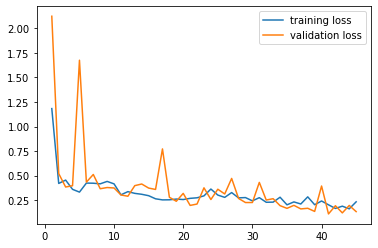

In [ ]:
tl1=[]
vl1=[]
a=[]
for i in tl:
    tl1.append(float(i))
for i in vl:
    vl1.append(float(i))
for i in range(1,46):
    a.append(i)
plt.plot(a,tl1,label='training loss')
plt.plot(a,vl1,label='validation loss')
plt.legend()

90.0

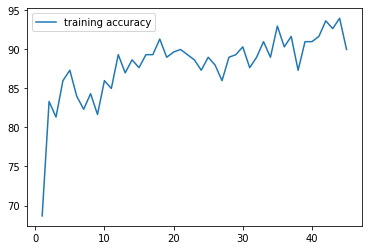

In [ ]:
ta1=[]
for i in ta:
    ta1.append(float(i))
plt.plot(a,ta1,label='training accuracy')
plt.legend()
ta1[-1]

In [ ]:
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

<All keys matched successfully>

In [ ]:
testa,testl=[],[]
def test(loaders, model, criterion, use_cuda):

    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output, target) 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        pred = output.data.max(1, keepdim=True)[1]
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
        print('Test Loss: {:.6f}\n'.format(test_loss))
        testl.append(float(test_loss))

        print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
            100. * correct / total, correct, total))
        testa.append(100. * correct / total)
        print('')

In [ ]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.033381


Test Accuracy: 100% ( 8/ 8)

Test Loss: 0.189485


Test Accuracy: 87% (14/16)

Test Loss: 0.133475


Test Accuracy: 91% (22/24)

Test Loss: 0.138146


Test Accuracy: 93% (30/32)

Test Loss: 0.147448


Test Accuracy: 92% (37/40)

Test Loss: 0.134850


Test Accuracy: 93% (45/48)

Test Loss: 0.118791


Test Accuracy: 94% (53/56)

Test Loss: 0.141078


Test Accuracy: 92% (59/64)

Test Loss: 0.175993


Test Accuracy: 90% (65/72)

Test Loss: 0.188510


Test Accuracy: 90% (72/80)

Test Loss: 0.192033


Test Accuracy: 89% (79/88)

Test Loss: 0.213909


Test Accuracy: 87% (84/96)

Test Loss: 0.209865


Test Accuracy: 88% (92/104)

Test Loss: 0.198967


Test Accuracy: 89% (100/112)

Test Loss: 0.189170


Test Accuracy: 90% (108/120)

Test Loss: 0.182451


Test Accuracy: 90% (116/128)

Test Loss: 0.183956


Test Accuracy: 90% (123/136)

Test Loss: 0.181088


Test Accuracy: 90% (131/144)

Test Loss: 0.183653


Test Accuracy: 90% (138/152)

Test Loss: 0.186447


Test Accuracy:

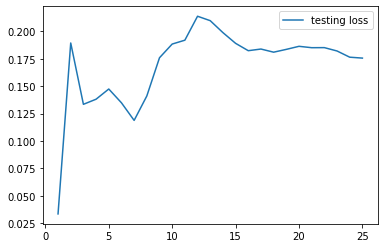

In [ ]:
testl1=[]
a=[]
for i in testl:
    testl1.append(float(i))
for i in range(len(testl1)):
    a.append(i+1)
plt.plot(a,testl1,label='testing loss')
plt.legend()

91.5


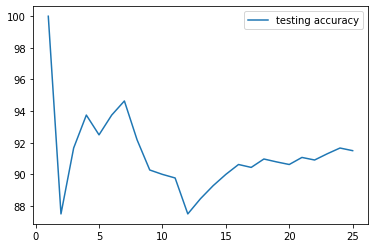

In [ ]:
testa1=[]
for i in testa:
    testa1.append(float(i))
print(testa1[-1])
plt.plot(a,testa1,label='testing accuracy')
plt.legend()